In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression

In [9]:
class LASSOAgent:
    def __init__(self, n: int, alpha: float = 0.05):
        self.n = n  # number of past observations to use
        self.alpha = alpha  # penalty parameter for the lasso regression
        self.signals_detected = [] # to keep track of the number of regressors used in each period


    def predict_price(self, ret_history: np.ndarray, theta_history: np.ndarray, last_price: float) -> float:
        """
        Predict next price based on LASSO regression of past returns on theta.
        
        Parameters:
            p_history (np.ndarray): historical prices (length T)
            theta_history (np.ndarray): historical theta values TxK matrix
            
        Returns:
            float: predicted price for next period
        """
        T = len(ret_history)
        if T < self.n + 1:
            raise ValueError(f"Not enough data. Require at least {self.n + 1} price points.")

        
        # Select last n observations
        X = theta_history[-self.n-1:-1, :]  # all features
        y = ret_history[-self.n-1:-1]  # returns

        # Use LASSO regression to estimate coefficients
        lasso = Lasso(alpha=self.alpha)
        lasso.fit(X, y)
        beta_hat = lasso.coef_
        self.signals_detected.append(np.sum(beta_hat != 0))

        # Predict next price
        theta_last = theta_history[-1, :]
        return (1 + beta_hat @ theta_last) * last_price, beta_hat
        

In [10]:
class Market:
    def __init__(self, T: int, agent: LASSOAgent, sigma_noise: float, 
                 initial_price: float = 100.0, seed: int = None):
        self.T = T
        self.agent = agent
        self.sigma_noise = sigma_noise
        self.initial_price = initial_price #p0
        self.seed = seed

        if seed is not None:
            np.random.seed(seed)
        
        # Generate theta values
        self.K = 10  # number of features in theta
        self.theta = np.random.normal(0, 1, (T, self.K))

        # Initialize price and return history
        self.prices = [initial_price] # p0
        self.returns = []
        self.beta_history = []

    def run_simulation(self):
        for t in range(self.T):
            if len(self.returns) < self.agent.n + 1:
                # Not enough data yet: assume price stays constant
                predicted_price = self.prices[-1] # p_t
                beta_hat = np.zeros(self.K)
            else:
                predicted_price, beta_hat = self.agent.predict_price(
                    np.array(self.returns),
                    self.theta[:t,:],
                    self.prices[-1]
                )
            self.beta_history.append(beta_hat)
            # Add noise to predicted price
            noise = np.random.normal(0, self.sigma_noise)
            true_price = predicted_price + noise # compute p_t = p_hat + noise

            # Compute return
            last_price = self.prices[-1] # p_{t-1}
            ret = (true_price - last_price) / last_price #r_t

            # Update histories
            self.prices.append(true_price)
            self.returns.append(ret)

        return np.array(self.returns)


In [18]:
# Initialize agent and market
agent = LASSOAgent(n=100, alpha=0.001)
market = Market(T=1000, agent=agent, sigma_noise=10, initial_price=100, seed=None)

# Run the simulation
return_path = market.run_simulation()

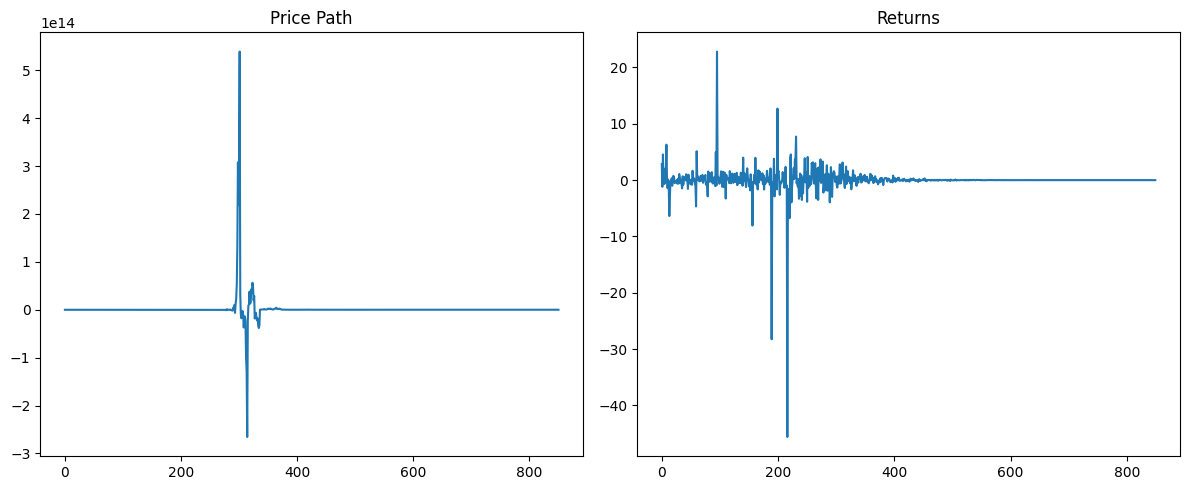

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(market.prices[150:])
plt.title("Price Path")

plt.subplot(1,2,2)
plt.plot(return_path[150:])
#add beta history
#plt.plot(market.beta_history[150:], label='Beta Coefficient', color='orange')
plt.title("Returns")
plt.tight_layout()
plt.show()